<a href="https://colab.research.google.com/github/Ranazzi/GANparam/blob/main/ProjetoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from __future__ import print_function, division

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import sys
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np


In [3]:
!pip install mat73

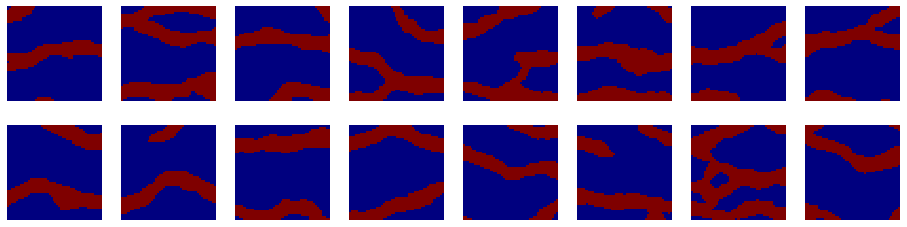

In [10]:
# Load the dataset
import mat73
X_train_raw = mat73.loadmat('gdrive/My Drive/Colab Notebooks/Projeto/C10000.mat')['chan10000']

X_train_raw = np.reshape(X_train_raw, (50, 50, 10000))
X_train_raw = np.einsum('xyn->nxy', X_train_raw)

r, c = 2, 8
figure, axs = plt.subplots(r, c,figsize=(c*2, r*2))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(X_train_raw[cnt,:,:], cmap = cm.jet, aspect = 'equal', interpolation = 'none')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()


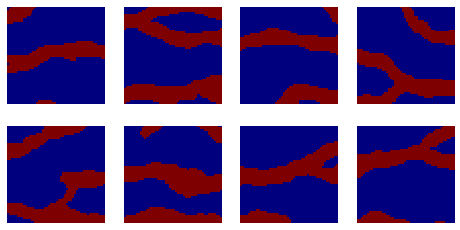

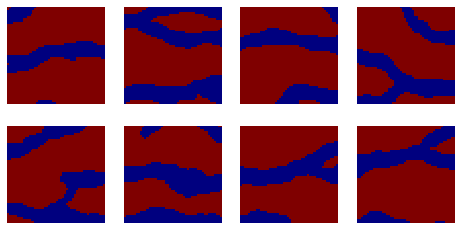

In [14]:
# #decompose into two channels
X_train=np.zeros((X_train_raw.shape[0],X_train_raw.shape[1],X_train_raw.shape[2],2))
for i in range(X_train_raw.shape[0]):
  for j in range(X_train_raw.shape[1]):
    for k in range(X_train_raw.shape[2]):
      if X_train_raw[i,j,k]==1:
        X_train[i,j,k,0]=1
        X_train[i,j,k,1]=-1
      else:
        X_train[i,j,k,1]=1
        X_train[i,j,k,0]=-1

r, c = 2, 4
figure, axs = plt.subplots(r, c,figsize=(c*2, r*2))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(X_train[cnt,:,:,0], cmap = cm.jet, aspect = 'equal', interpolation = 'none')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()
r, c = 2, 4
figure, axs = plt.subplots(r, c,figsize=(c*2, r*2))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(X_train[cnt,:,:,1], cmap = cm.jet, aspect = 'equal', interpolation = 'none')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()

In [24]:
def build_generator(latent_dim, img_shape):
  model = Sequential()

  model.add(layers.Dense(7*7*128, activation = 'relu', input_dim=latent_dim)) #camada densa
  model.add(layers.Reshape((7, 7, 128))) #reshape

  model.add(layers.UpSampling2D()) #upsampling (aumenta o número de linhas)
  model.add(layers.Conv2D(128, kernel_size=2, strides=1, padding="valid")) #convd2 3x3 com stride de 1

  model.add(layers.UpSampling2D()) #upsampling (aumenta o número de linhas)
  model.add(layers.Conv2D(128, kernel_size=3, strides=1, padding="same")) #convd2 3x3 com stride de 1
  model.add(layers.BatchNormalization(momentum=0.8)) #batch normalization
  model.add(layers.Activation("relu")) #camada de ativação com função relu

  model.add(layers.UpSampling2D())
  model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding="valid")) #convd2 3x3 com stride de 1
  model.add(layers.Conv2D(32, kernel_size=3, strides=1, padding="same")) #convd2 3x3 com stride de 1
  model.add(layers.BatchNormalization(momentum=0.8)) #batch normalization
  model.add(layers.Activation("relu")) #camada de ativação com função relu

  model.add(layers.Conv2D(2, kernel_size=3, strides=1, padding="same", activation = 'tanh')) #convd2 3x3 com stride de 1 e actv tanh

  # model.summary()
  
  noise = layers.Input(shape=(latent_dim,))
  img = model(noise)

  return Model(noise, img)

def build_discriminator(img_shape):

  model = Sequential()

  model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
  # model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
  # model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
  # model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
  # model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  # model.summary()

  img = layers.Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

def sample_images(iter, generator):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r * c, latent_dim))
  gen_imgs = generator.predict(noise)

  #get maximum activation value as facie type
  faciet=np.zeros((gen_imgs.shape[0],gen_imgs.shape[1],gen_imgs.shape[2]))

  for i in range(gen_imgs.shape[0]):
   for j in range(gen_imgs.shape[1]):
    for k in range(gen_imgs.shape[2]):
      if gen_imgs[i,j,k,0] > gen_imgs[i,j,k,1]:
        faciet[i,j,k]=1

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(faciet[cnt,:,:], aspect='equal', cmap = cm.jet, interpolation = 'none',clim = (0, 1))
          axs[i,j].axis('off')
          cnt += 1
  plt.show()
  plt.close()

In [25]:
img_shape = (50, 50, 2)
latent_dim = 500

optimizer = Adam(0.0002, 0.5)

# Constrói e compila o discriminador
discriminator = build_discriminator(img_shape)
discriminator.summary()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])


# Constrói o gerador
generator = build_generator(latent_dim, img_shape)

# O gerador recebe ruído aleatório como entrada, e retorna imagens como saída
z = layers.Input(shape=(latent_dim,))
img = generator(z)

# Para o modelo combinado, treinamos apenas o gerador
discriminator.trainable = False

# O discriminador recebe imagens geradas e reais como entrada, e as classifica entre essas duas classes.
validity = discriminator(img)

# O modelo combinado (gerador e discriminador) é utilizado para treinar o gerador a "enganar" o discriminador.
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
print(combined.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 50, 2)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 1)                 400673    
                                                                 
Total params: 400,673
Trainable params: 400,673
Non-trainable params: 0
_________________________________________________________________
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500)]             0         
                                                                 
 model_4 (Functional)        (None, 50, 50, 2)         3448994   
                                                                 
 model_3 (Functional)        (None, 

In [26]:
#normalization
batch_size=64
# Re-escale de -1 a 1
# X_train = X_train / 127.5 - 1.
# X_train = np.expand_dims(X_train, axis=3)

# Ground truth para treinamento. Reais -> 1; Sintéticas (falsas) -> 0
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

0 [D loss: 0.683451, acc.: 43.75%] [G loss: 0.589269]


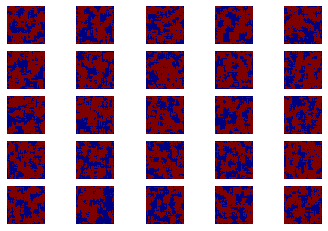

25 [D loss: 0.719423, acc.: 46.09%] [G loss: 0.623099]


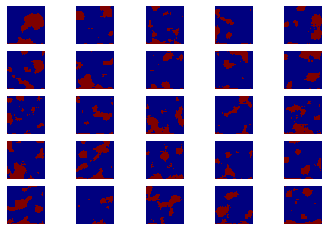

50 [D loss: 0.696541, acc.: 49.22%] [G loss: 0.646057]


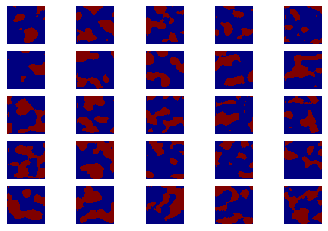

75 [D loss: 1.111286, acc.: 43.75%] [G loss: 0.365317]


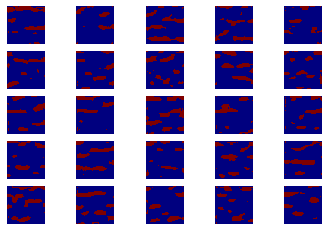

100 [D loss: 0.687573, acc.: 49.22%] [G loss: 0.684204]


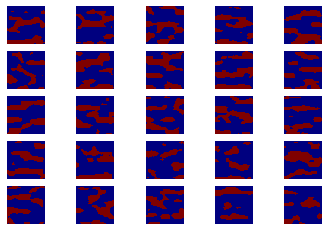

125 [D loss: 0.665527, acc.: 63.28%] [G loss: 0.606484]


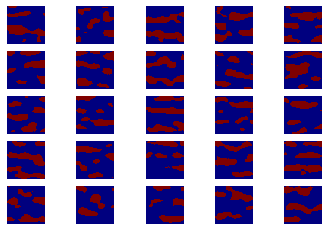

150 [D loss: 0.684359, acc.: 53.91%] [G loss: 0.705003]


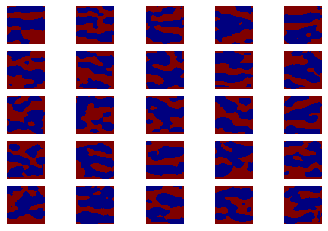

175 [D loss: 0.567683, acc.: 87.50%] [G loss: 1.087221]


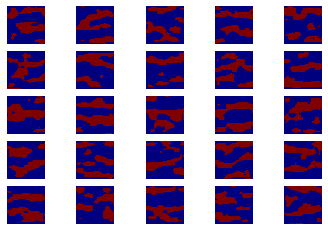

200 [D loss: 0.715452, acc.: 44.53%] [G loss: 0.798172]


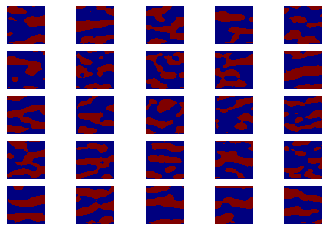

225 [D loss: 0.546013, acc.: 89.06%] [G loss: 0.426058]


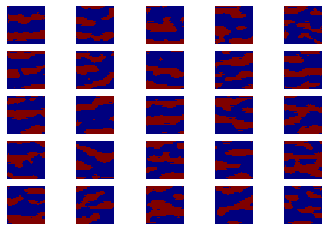

250 [D loss: 0.694546, acc.: 53.91%] [G loss: 0.987130]


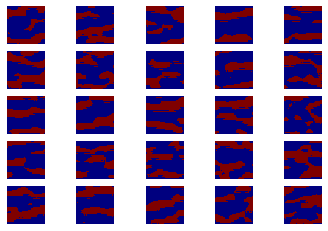

275 [D loss: 0.594862, acc.: 73.44%] [G loss: 0.944041]


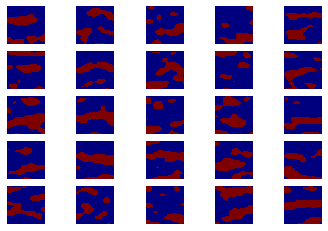

300 [D loss: 0.500877, acc.: 86.72%] [G loss: 1.308301]


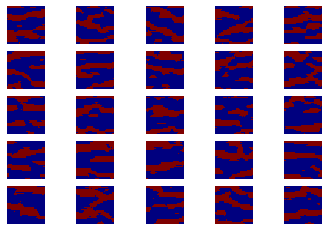

325 [D loss: 0.520416, acc.: 77.34%] [G loss: 1.599607]


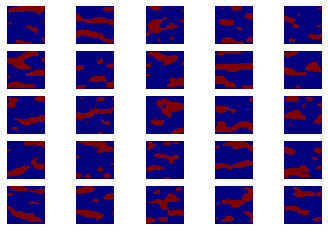

350 [D loss: 0.199513, acc.: 96.09%] [G loss: 0.529832]


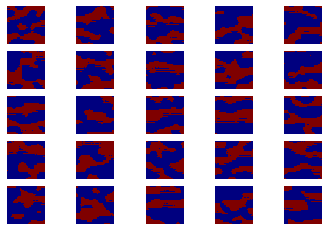

375 [D loss: 0.518032, acc.: 74.22%] [G loss: 1.678572]


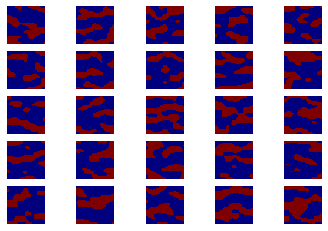

400 [D loss: 0.514911, acc.: 73.44%] [G loss: 1.971338]


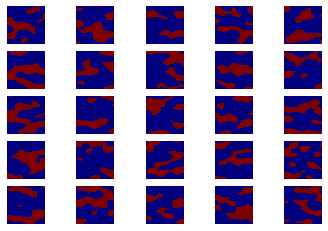

425 [D loss: 0.348453, acc.: 84.38%] [G loss: 0.997061]


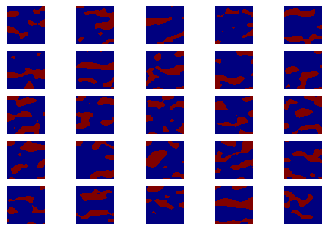

450 [D loss: 0.409657, acc.: 82.81%] [G loss: 1.286557]


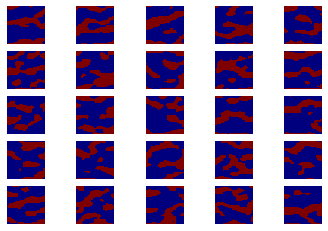

475 [D loss: 0.417341, acc.: 79.69%] [G loss: 2.663477]


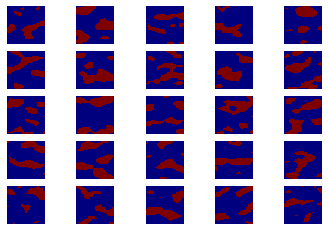

500 [D loss: 0.115522, acc.: 93.75%] [G loss: 0.082712]


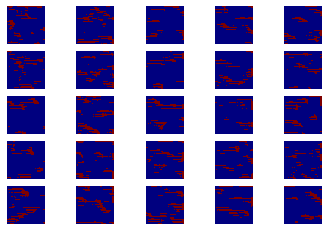

525 [D loss: 0.430385, acc.: 82.81%] [G loss: 2.367906]


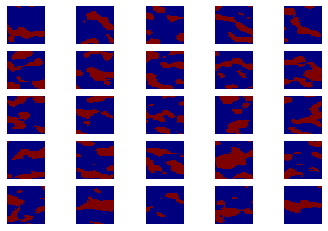

550 [D loss: 0.322121, acc.: 86.72%] [G loss: 1.949552]


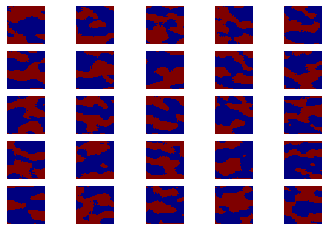

575 [D loss: 0.385875, acc.: 82.81%] [G loss: 2.805822]


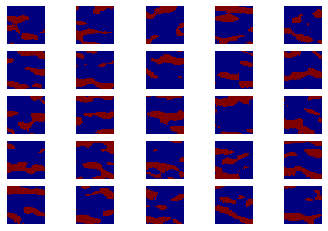

600 [D loss: 0.135817, acc.: 95.31%] [G loss: 0.244818]


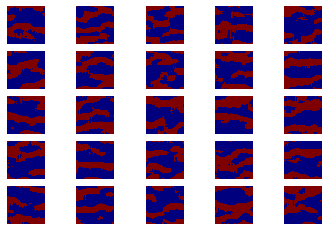

625 [D loss: 0.321863, acc.: 82.81%] [G loss: 2.713206]


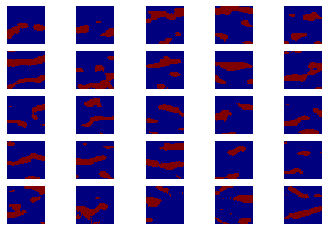

650 [D loss: 0.093833, acc.: 96.09%] [G loss: 2.354380]


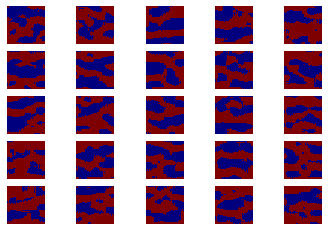

675 [D loss: 0.392277, acc.: 84.38%] [G loss: 3.218808]


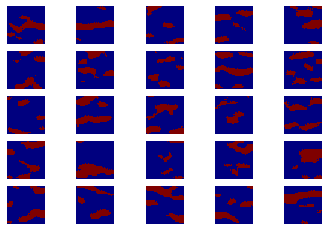

700 [D loss: 0.120740, acc.: 97.66%] [G loss: 1.532605]


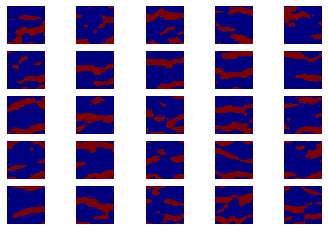

725 [D loss: 0.341202, acc.: 82.03%] [G loss: 2.986758]


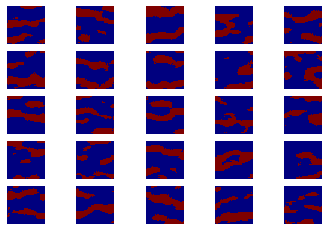

750 [D loss: 0.169263, acc.: 93.75%] [G loss: 2.997766]


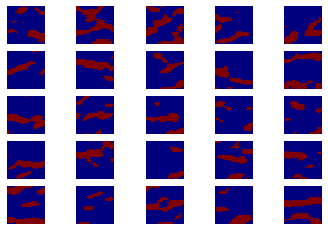

775 [D loss: 0.099192, acc.: 96.09%] [G loss: 1.125999]


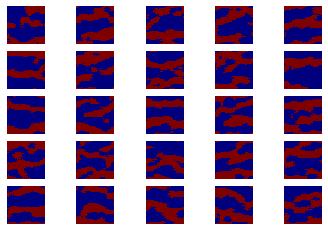

800 [D loss: 0.271238, acc.: 89.84%] [G loss: 3.161412]


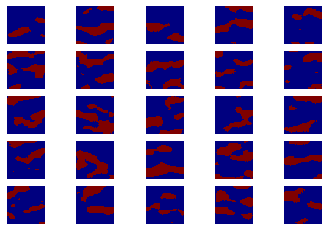

825 [D loss: 0.084130, acc.: 96.09%] [G loss: 0.247443]


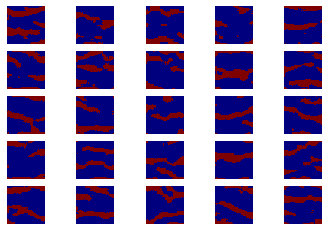

850 [D loss: 0.280513, acc.: 89.84%] [G loss: 2.845980]


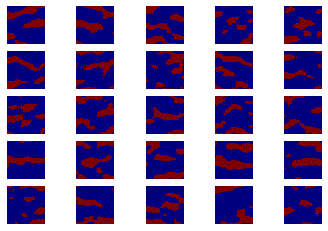

875 [D loss: 0.257802, acc.: 89.84%] [G loss: 1.574011]


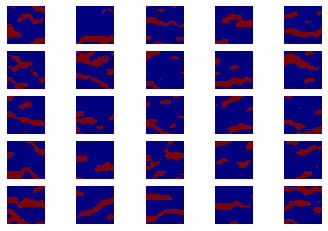

900 [D loss: 0.472373, acc.: 75.78%] [G loss: 2.270400]


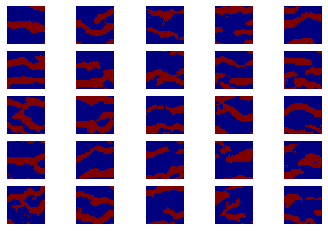

925 [D loss: 0.292216, acc.: 86.72%] [G loss: 2.013272]


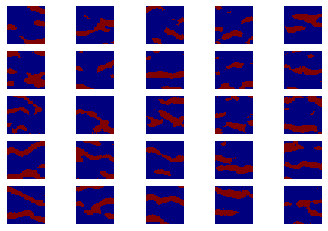

950 [D loss: 0.432188, acc.: 78.91%] [G loss: 0.658153]


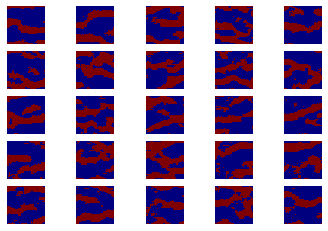

975 [D loss: 0.142203, acc.: 92.97%] [G loss: 0.986821]


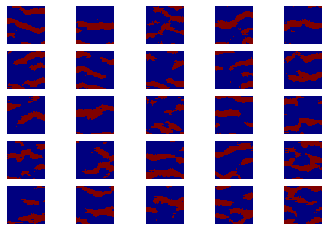

1000 [D loss: 0.547397, acc.: 75.00%] [G loss: 2.537449]


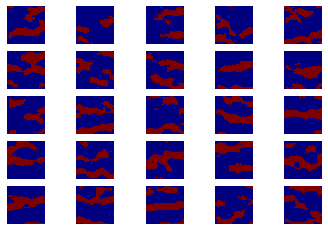

1025 [D loss: 0.695385, acc.: 70.31%] [G loss: 4.333839]


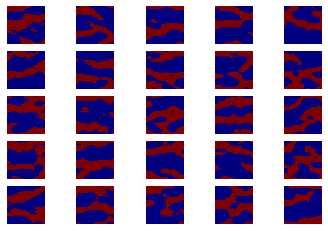

1050 [D loss: 0.421140, acc.: 83.59%] [G loss: 2.616584]


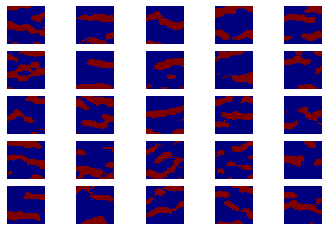

1075 [D loss: 0.758924, acc.: 55.47%] [G loss: 3.078875]


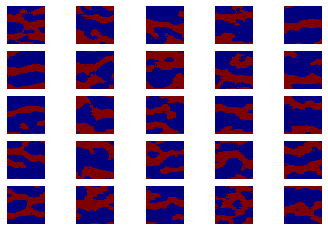

1100 [D loss: 0.574686, acc.: 70.31%] [G loss: 2.841459]


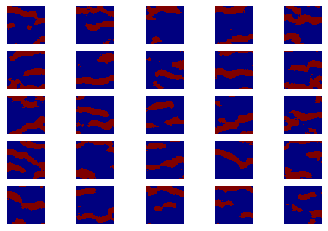

1125 [D loss: 0.247703, acc.: 89.84%] [G loss: 0.729459]


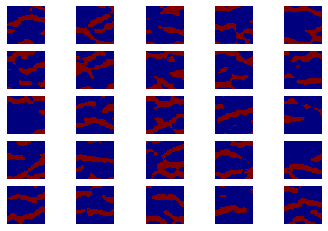

1150 [D loss: 0.292417, acc.: 86.72%] [G loss: 1.529418]


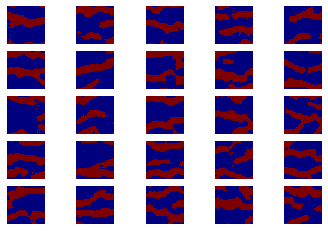

1175 [D loss: 0.394509, acc.: 82.81%] [G loss: 2.160948]


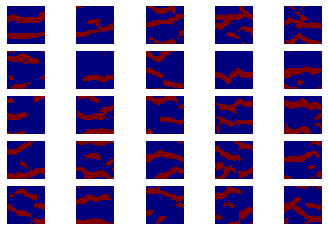

1200 [D loss: 0.310667, acc.: 84.38%] [G loss: 1.598257]


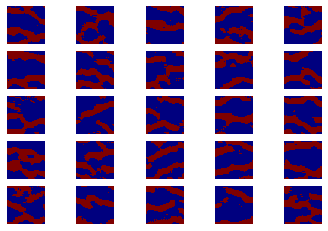

1225 [D loss: 0.221517, acc.: 93.75%] [G loss: 2.146163]


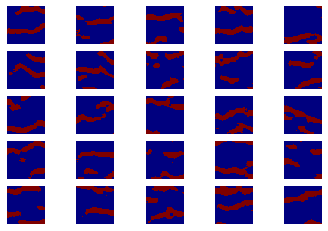

1250 [D loss: 0.098149, acc.: 98.44%] [G loss: 0.977042]


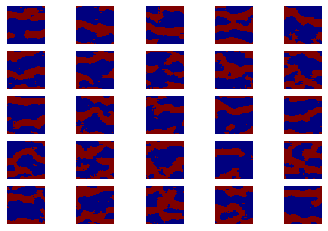

1275 [D loss: 0.181917, acc.: 92.97%] [G loss: 1.468372]


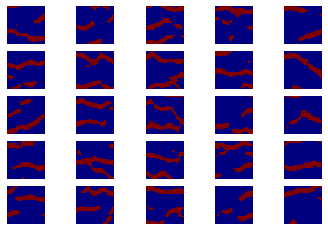

1300 [D loss: 0.094752, acc.: 96.09%] [G loss: 1.104529]


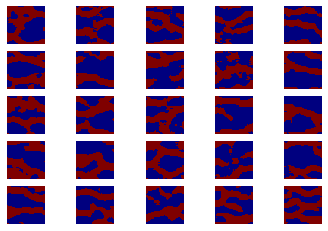

1325 [D loss: 0.340412, acc.: 82.81%] [G loss: 3.657278]


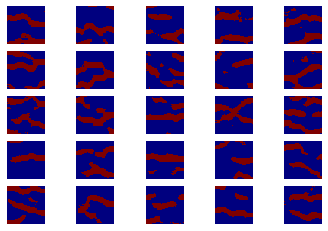

1350 [D loss: 0.218587, acc.: 92.97%] [G loss: 1.635553]


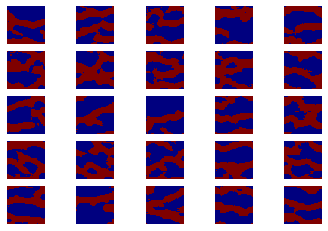

1375 [D loss: 0.434144, acc.: 75.78%] [G loss: 2.512833]


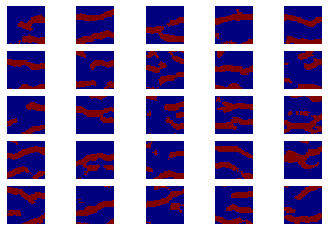

1400 [D loss: 0.420886, acc.: 78.91%] [G loss: 3.280648]


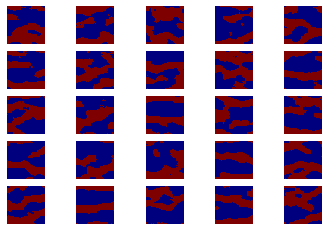

1425 [D loss: 0.304095, acc.: 85.16%] [G loss: 3.037842]


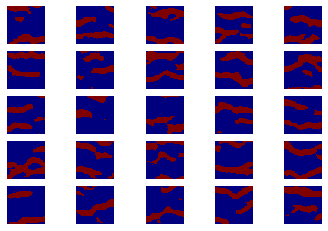

1450 [D loss: 0.546486, acc.: 68.75%] [G loss: 2.209849]


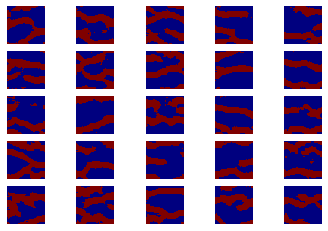

1475 [D loss: 0.379013, acc.: 82.81%] [G loss: 2.028333]


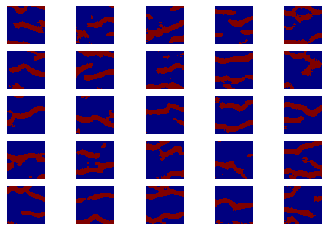

1500 [D loss: 0.403270, acc.: 79.69%] [G loss: 2.776878]


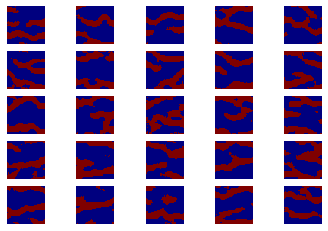

1525 [D loss: 0.453618, acc.: 79.69%] [G loss: 2.380492]


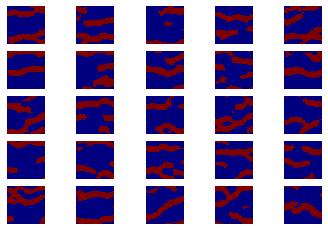

1550 [D loss: 0.419827, acc.: 78.12%] [G loss: 1.815295]


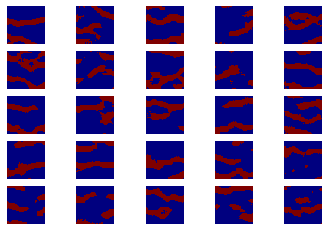

1575 [D loss: 0.444312, acc.: 79.69%] [G loss: 2.153584]


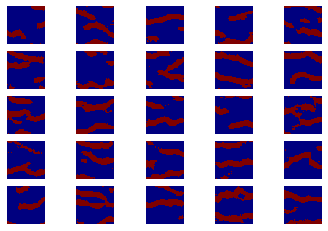

1600 [D loss: 0.497154, acc.: 73.44%] [G loss: 2.611823]


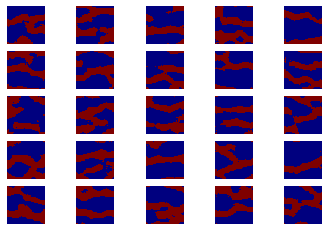

1625 [D loss: 0.465436, acc.: 78.91%] [G loss: 2.217851]


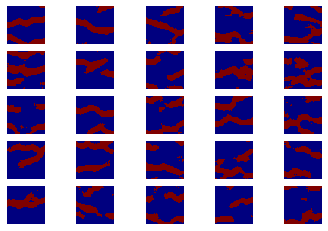

1650 [D loss: 0.371920, acc.: 85.16%] [G loss: 1.996841]


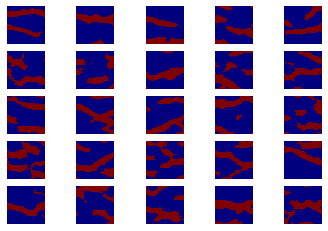

1675 [D loss: 0.499256, acc.: 71.88%] [G loss: 2.247323]


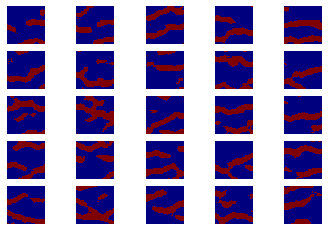

1700 [D loss: 0.578359, acc.: 71.09%] [G loss: 2.078813]


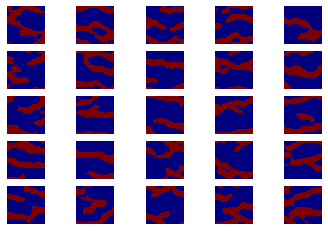

1725 [D loss: 0.381243, acc.: 85.16%] [G loss: 1.998623]


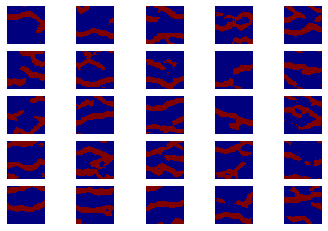

1750 [D loss: 0.487042, acc.: 79.69%] [G loss: 2.166826]


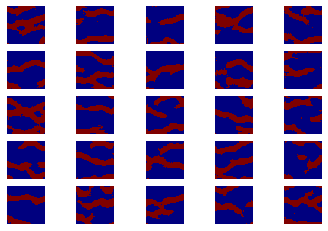

1775 [D loss: 0.300710, acc.: 89.06%] [G loss: 2.331815]


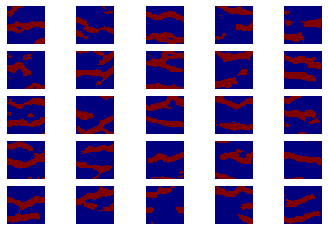

1800 [D loss: 0.483750, acc.: 78.12%] [G loss: 2.129210]


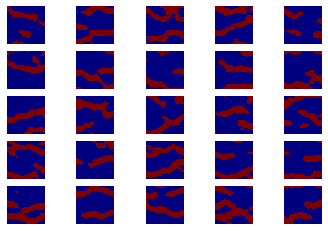

1825 [D loss: 0.350786, acc.: 83.59%] [G loss: 2.239579]


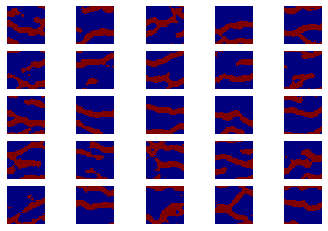

1850 [D loss: 0.467925, acc.: 75.00%] [G loss: 2.110157]


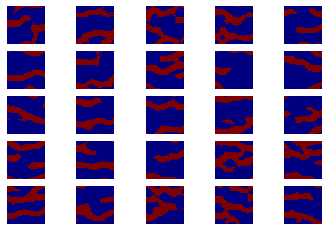

1875 [D loss: 0.459994, acc.: 75.00%] [G loss: 1.746146]


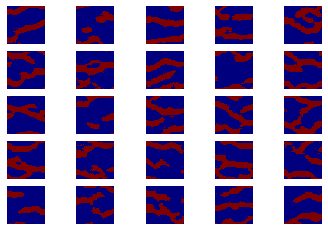

1900 [D loss: 0.477628, acc.: 75.78%] [G loss: 2.470867]


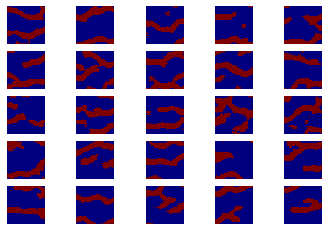

1925 [D loss: 0.554490, acc.: 71.09%] [G loss: 2.568015]


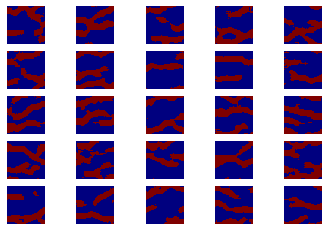

1950 [D loss: 0.515177, acc.: 75.00%] [G loss: 2.505659]


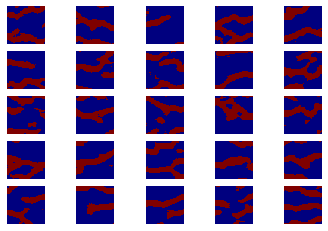

1975 [D loss: 0.477482, acc.: 75.00%] [G loss: 2.790671]


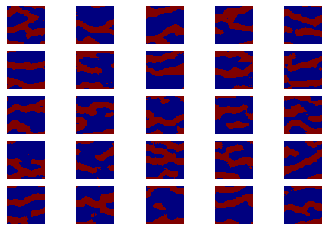

2000 [D loss: 0.524670, acc.: 69.53%] [G loss: 2.153722]


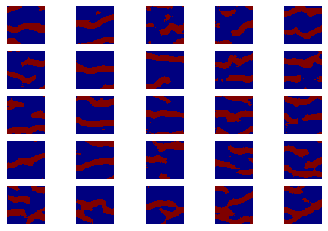

2025 [D loss: 0.425727, acc.: 80.47%] [G loss: 2.541837]


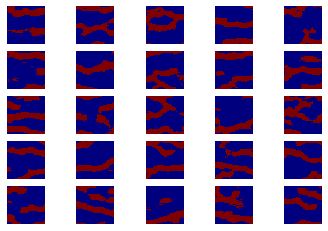

2050 [D loss: 0.383360, acc.: 78.91%] [G loss: 1.939459]


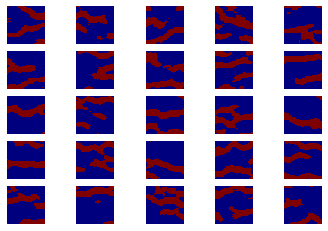

2075 [D loss: 0.380044, acc.: 83.59%] [G loss: 1.767411]


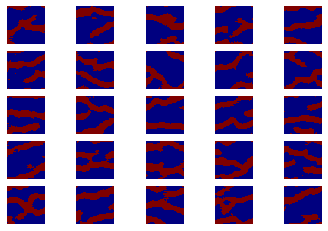

2100 [D loss: 0.398039, acc.: 81.25%] [G loss: 2.348263]


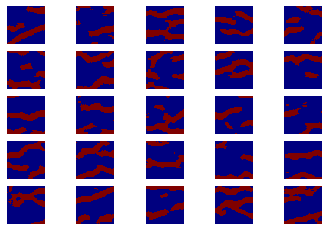

2125 [D loss: 0.418372, acc.: 79.69%] [G loss: 2.233175]


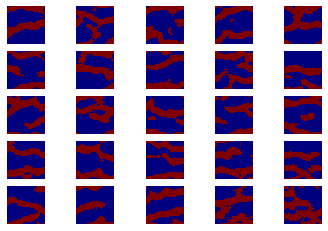

2150 [D loss: 0.473904, acc.: 81.25%] [G loss: 1.820335]


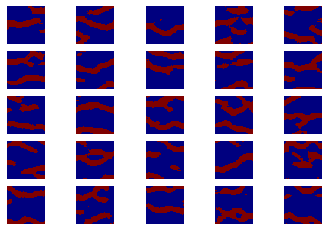

2175 [D loss: 0.359722, acc.: 83.59%] [G loss: 1.949034]


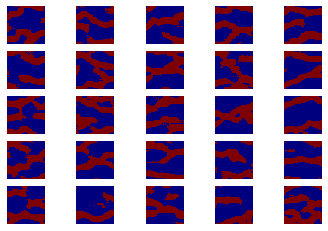

2200 [D loss: 0.319488, acc.: 86.72%] [G loss: 2.223310]


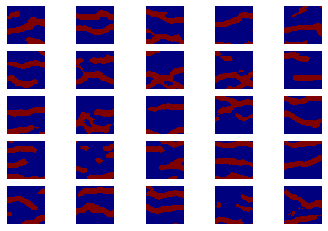

2225 [D loss: 0.416767, acc.: 82.81%] [G loss: 2.149595]


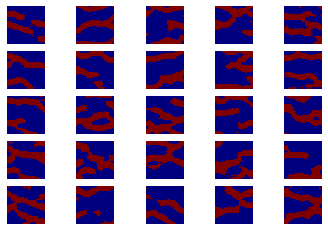

2250 [D loss: 0.439758, acc.: 78.91%] [G loss: 2.565919]


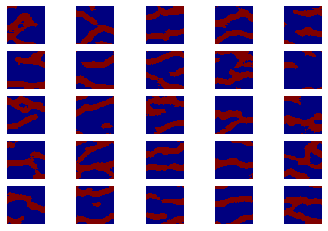

2275 [D loss: 0.376046, acc.: 83.59%] [G loss: 2.427077]


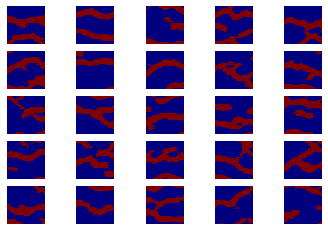

2300 [D loss: 0.473390, acc.: 78.91%] [G loss: 2.496080]


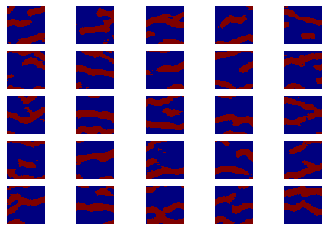

2325 [D loss: 0.404862, acc.: 82.03%] [G loss: 2.376275]


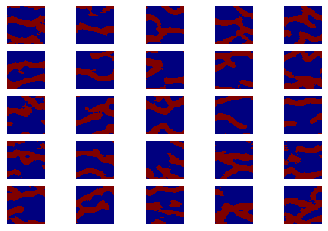

2350 [D loss: 0.418829, acc.: 77.34%] [G loss: 2.262242]


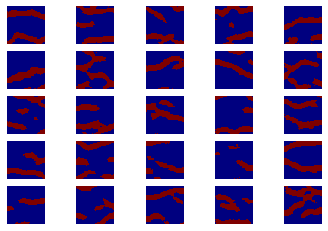

2375 [D loss: 0.436265, acc.: 77.34%] [G loss: 1.813149]


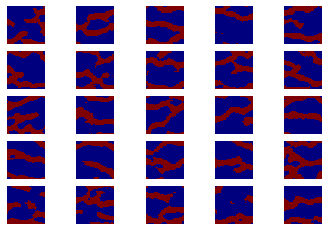

2400 [D loss: 0.481715, acc.: 77.34%] [G loss: 2.874153]


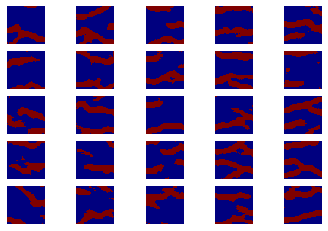

2425 [D loss: 0.360648, acc.: 85.16%] [G loss: 1.840768]


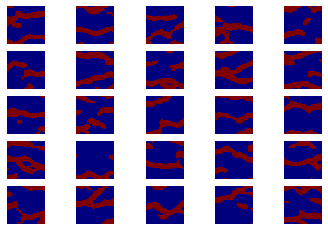

2450 [D loss: 0.374793, acc.: 83.59%] [G loss: 2.215650]


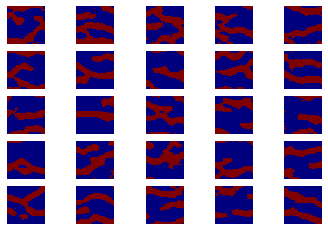

2475 [D loss: 0.397642, acc.: 86.72%] [G loss: 2.098112]


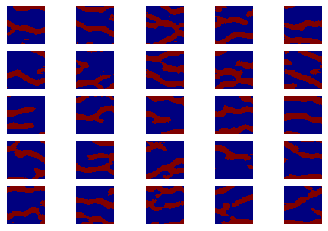

2500 [D loss: 0.673353, acc.: 62.50%] [G loss: 2.143485]


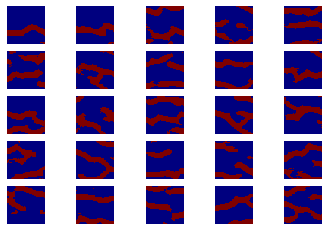

2525 [D loss: 0.377761, acc.: 82.81%] [G loss: 2.665650]


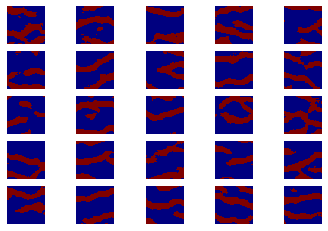

2550 [D loss: 0.463456, acc.: 78.12%] [G loss: 2.423659]


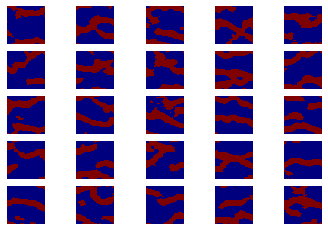

2575 [D loss: 0.431395, acc.: 78.12%] [G loss: 2.214302]


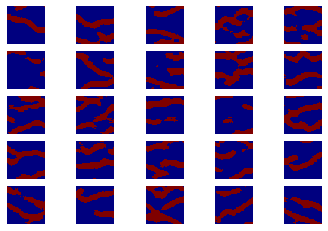

2600 [D loss: 0.335946, acc.: 82.81%] [G loss: 2.065186]


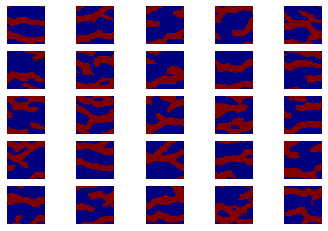

2625 [D loss: 0.470090, acc.: 78.91%] [G loss: 2.019932]


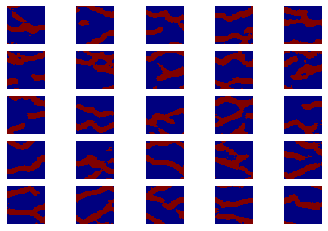

2650 [D loss: 0.462089, acc.: 79.69%] [G loss: 2.411422]


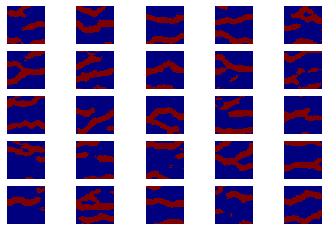

2675 [D loss: 0.492839, acc.: 75.78%] [G loss: 2.105866]


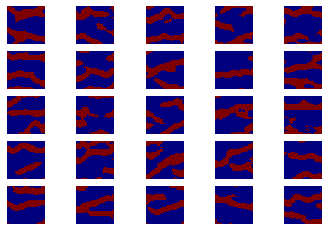

2700 [D loss: 0.629964, acc.: 67.19%] [G loss: 2.249083]


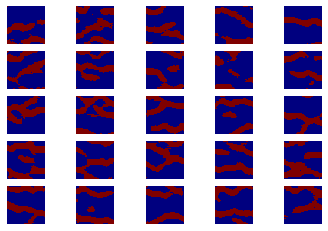

2725 [D loss: 0.435850, acc.: 81.25%] [G loss: 2.282102]


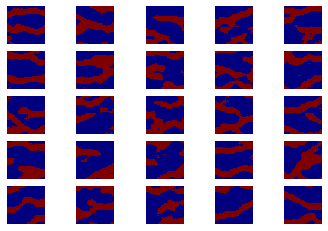

2750 [D loss: 0.453754, acc.: 82.03%] [G loss: 2.198473]


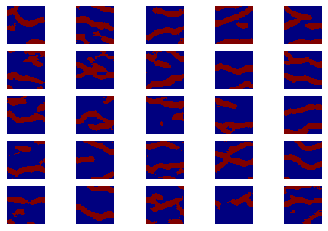

2775 [D loss: 0.406692, acc.: 85.16%] [G loss: 2.441667]


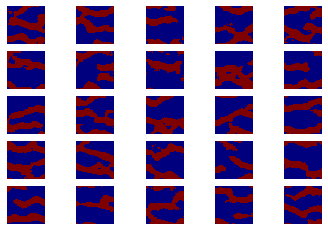

2800 [D loss: 0.427729, acc.: 78.12%] [G loss: 2.471510]


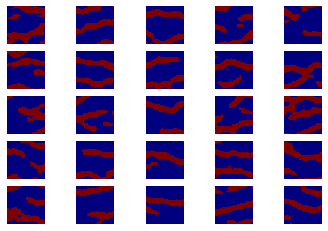

2825 [D loss: 0.478264, acc.: 77.34%] [G loss: 2.484643]


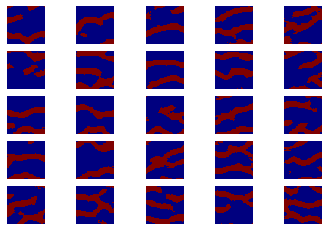

2850 [D loss: 0.562564, acc.: 73.44%] [G loss: 2.110899]


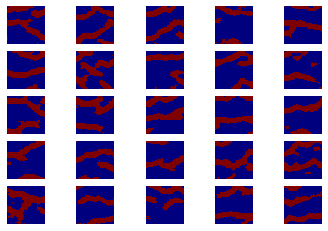

2875 [D loss: 0.457133, acc.: 78.12%] [G loss: 2.059625]


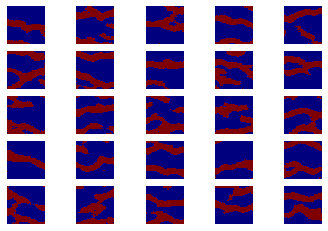

2900 [D loss: 0.320626, acc.: 91.41%] [G loss: 2.076871]


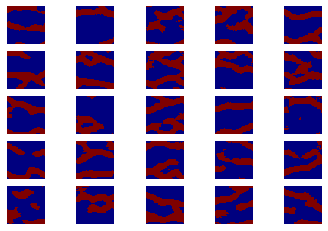

2925 [D loss: 0.344810, acc.: 85.16%] [G loss: 2.387941]


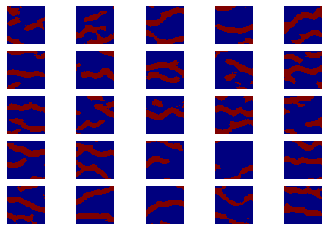

2950 [D loss: 0.384925, acc.: 78.91%] [G loss: 2.042634]


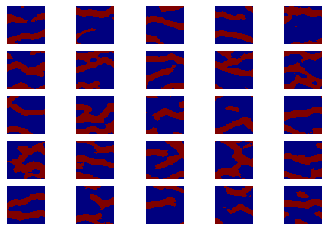

2975 [D loss: 0.417137, acc.: 80.47%] [G loss: 2.427535]


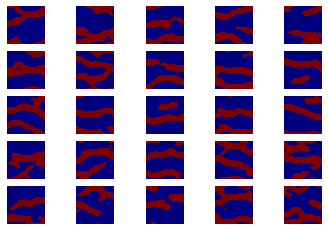

In [27]:
iterations=3000
sample_interval=25

for iter in range(iterations):

  # ---------------------
  #  Treino do Discriminador
  # ---------------------

  # Selecione um batch aleatório de imagens
  idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
  imgs = X_train[idx]

  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Gere um batch de imagens sintéticas.
  gen_imgs = generator.predict(noise)

  # Treine o discriminador:
  #    Com imagens reais
  d_loss_real = discriminator.train_on_batch(imgs, valid)
  #    Com imagens sintéticas:
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  # Faça a média das duas.
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # ---------------------
  #  Treino do Gerador
  # ---------------------

  # Amostragem de um ruído aleatório
  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Treine o gerador, de forma a enganar o discriminador (tentar fazer que ele as classifique as imagens geradas como reais -> passamos 'valid' como ground truth). 
  # Por esse motivo "congelamos" os pesos do discriminador para esse passo!!!
  g_loss = combined.train_on_batch(noise, valid)

  # Plote o progresso a cada 'sample_interval' iterações
  if iter % sample_interval == 0:
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iter, d_loss[0], 100*d_loss[1], g_loss))
      sample_images(iter, generator)

In [ ]:

noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = generator.predict(noise)

# gen_imgs[gen_imgs>0]=1
# gen_imgs[gen_imgs<0]=0

r, c = 2, 8
figure, axs = plt.subplots(r, c,figsize=(c*2, r*2))
cnt = 0
for i in range(r):
    for j in range(c):
        a=axs[i,j].imshow(gen_imgs[cnt,:,:,0], aspect='equal', cmap = cm.jet, interpolation = 'none', clim = (0, 1))
        axs[i,j].axis('off')
        cnt += 1

plt.subplots_adjust(bottom=0.1, right=0.82, top=0.9)
cax = plt.axes([0.85, 0.1, 0.015, 0.8])
plt.colorbar(a,cax=cax)
plt.show()
plt.close()